In [1]:
from datetime import datetime

import pandas as pd

# Hourly electricity production estimation by fuel source for South Korea

## 1. Process demand/consumption data

Forecast data source
http://www.kpx.or.kr/www/contents.do?key=223
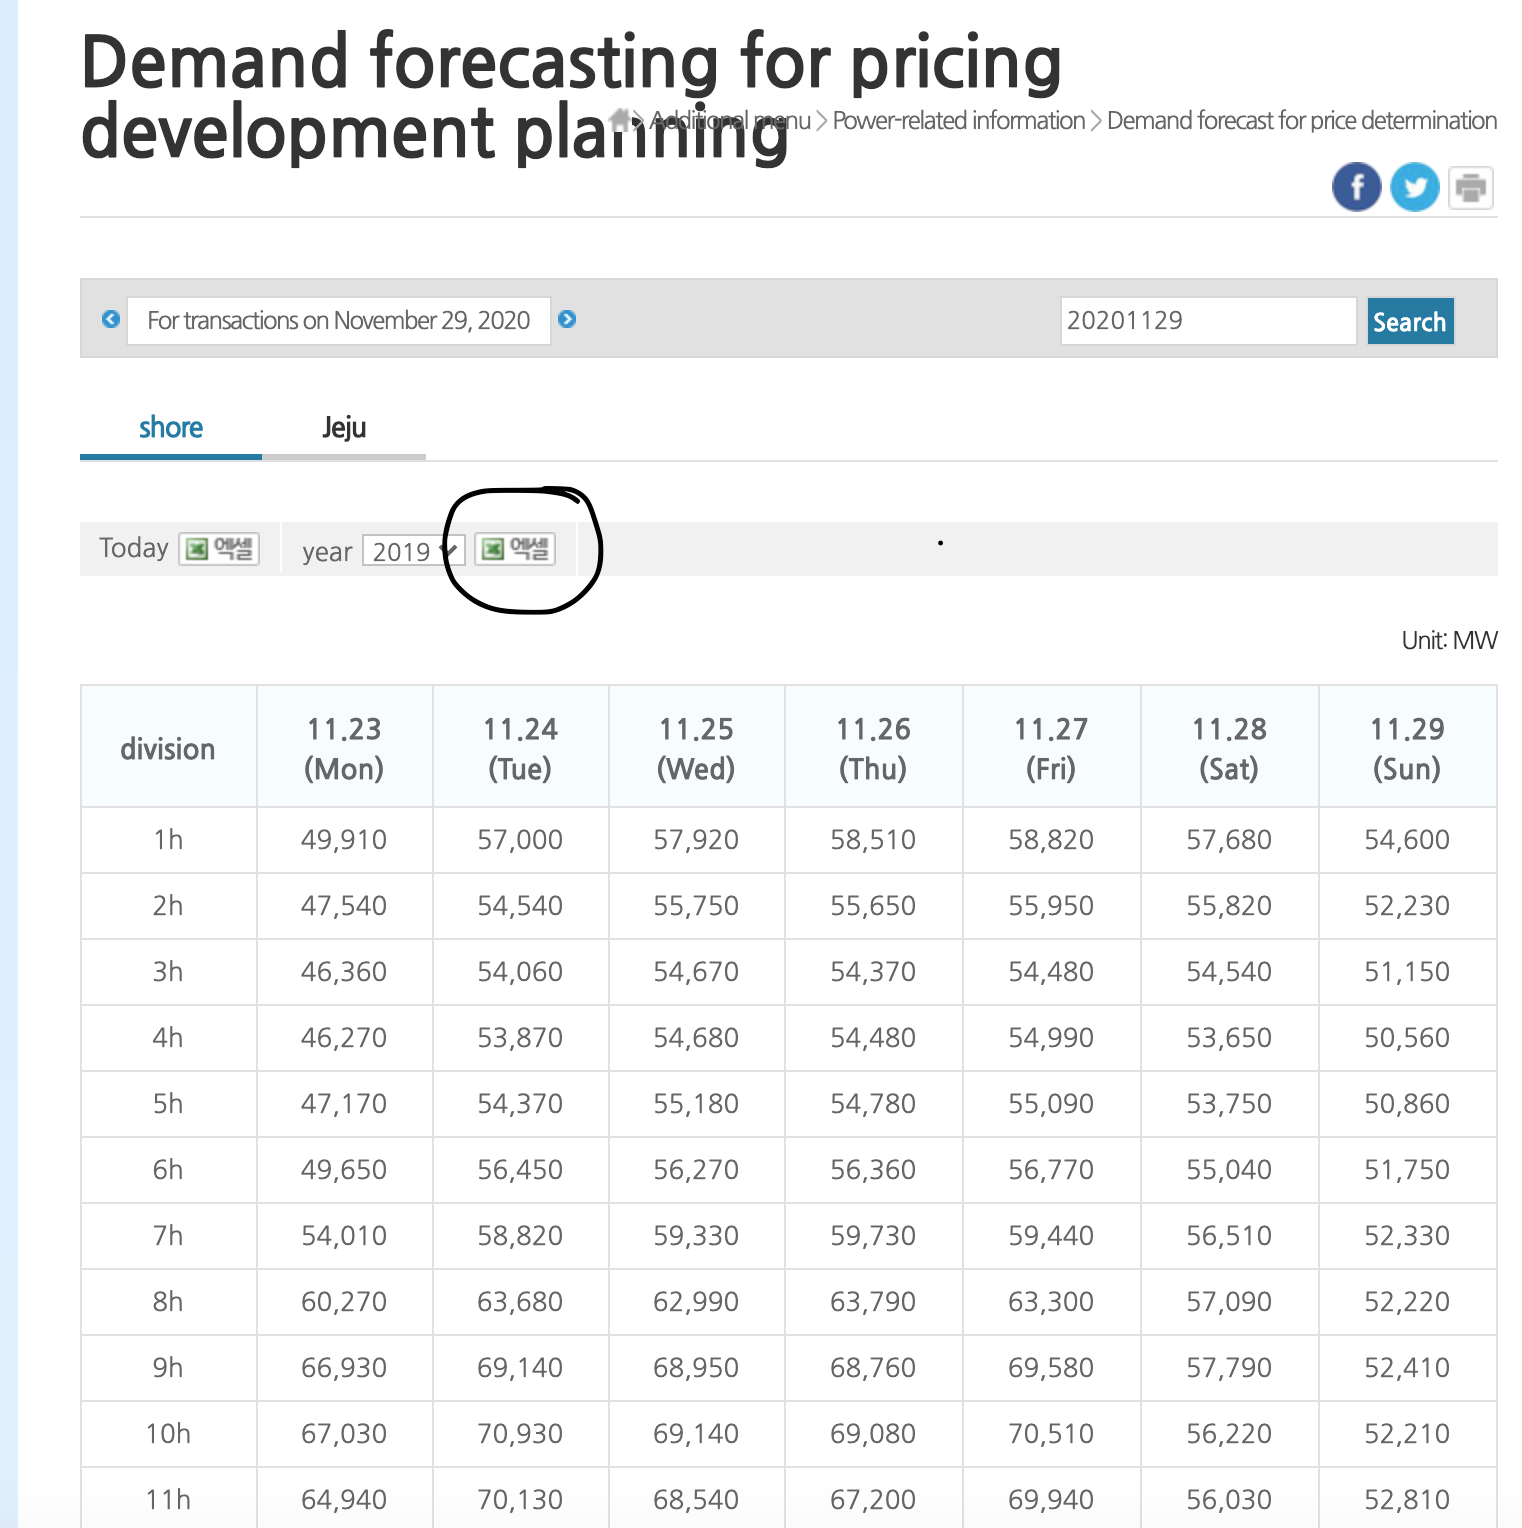

In [2]:
df_prod = pd.read_excel('../data/input/bidforecastgen_land_2019.xls')

In [3]:
df_prod.head()

,일자별 수요예측 리스트,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,단위 : MW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,구분,1h,2h,3h,4h,5h,6h,7h,8h,9h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
3,20190101,60140,57700,56170,55200,55200,55770,56130,55240,54170,...,53400,54390,55750,58740,60340,60450,60160,59890,60870,61870
4,20190102,64520,62750,61770,61480,61880,63360,66030,70680,77640,...,77090,77280,78450,78290,76580,74700,73310,71540,70560,71670


In [4]:
def process_production(df):
    """Transforms the KR data to the right format"""
    # the row with index 2 will be used as column names
    rename_dict = dict(zip(df.columns[1:], df.iloc[2, 1:].values))
    # the first column is date (in korean)
    rename_dict[df.columns[0]] = 'date'
    df = df.rename(columns=rename_dict)
    
    # the first 3 rows contain null values and the column names
    df = df.drop(index=range(3))
    
    df['date'] = pd.to_datetime(df['date'])
    
    # convert all columns except for date to integers
    int_columns = [col for col in df.columns if col!='date']
    df[int_columns] = df[int_columns].astype(int)
    
    # change dataframe shape from wide to long 
    # one row per hour instead of 1 column per hour
    df = df.melt(id_vars='date', value_name='total_consumption_average', var_name='hour')
    
    # convert e.g. 1h to 1:00
    df.loc[df.hour=='24h', 'hour'] = '0h'
    df['hour'] = df['hour'].apply(lambda x: x[:(len(x))-1] + ':00')
    
    # create datetime from date and hour
    df['datetime'] = df['date'].astype(str) + " " + df['hour']
    df['datetime'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M"))
    df['timestamp'] = df['datetime'].apply(lambda x: datetime.timestamp(x))
    
    df['zone_name'] = 'KR'
    
    df['month'] = df['datetime'].apply(lambda x: datetime.strftime(x, '%Y%m'))
    
    return df[['month', 'datetime', 'timestamp', 'zone_name', 'total_consumption_average']]
    

In [5]:
df_totals = process_production(df_prod)

In [6]:
df_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month                      8760 non-null   object        
 1   datetime                   8760 non-null   datetime64[ns]
 2   timestamp                  8760 non-null   float64       
 3   zone_name                  8760 non-null   object        
 4   total_consumption_average  8760 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 342.3+ KB


In [7]:
assert df_totals.shape[0] == 365*24

In [8]:
df_totals.to_csv('../data/intermediate/KR_hourly_2019.csv')

## 2. Process fuel source data

http://epsis.kpx.or.kr/epsisnew/selectEkpoBftChart.do?menuId=020100

In [9]:
df_fuel = pd.read_csv('../data/input/GenerationCapacity_byFuel.csv')

In [10]:
df_fuel.head()

,Period,Region,Nuclear,Bituminous\ncoal,Anthracite\ncoal,Oil,LNG,Pumped-Storage,New&Renewable energy,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Others*,Total
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fuel\nCell,IGCC,Solar\nPower,Wind\nPower,Hydro\nPower*,Marine\nEnergy*,Bio\nEnergy*,Waste\nEnergy,NaN,NaN
1,2020/11,Total,23250.0,36453.382,400.0,2246.962,41169.767,4700.0,605.0139999999999,346.33,14014.969069002602,1621.6023999999998,1805.4114000000002,255.5,1317.388,0,423.094,128609.419869
2,2020/10,Total,23250.0,36453.382,400.0,2100.717,41169.767,4700.0,607.2039999999998,346.33,13747.65158400265,1621.503,1805.4114000000002,255.5,1316.9379999999999,0,422.694,128197.097984
3,2020/09,Total,23250.0,36453.382,400.0,2100.717,41169.767,4700.0,606.2039999999998,346.33,13422.310105002462,1621.503,1805.5114,255.5,1217.238,0,1213.194,128561.656505
4,2020/08,Total,23250.0,36453.382,400.0,2100.717,41169.767,4700.0,561.824,346.33,13132.397375002263,1578.303,1805.5114,255.5,1110.7450000000003,0,1213.194,128077.670775


In [11]:
def process_fuel_types(df):
    """Transforms the fuel type data to the right format"""
    # use the first row as column names to fix nested structure
    rename_dict = dict(zip(df_fuel.columns[8:-2], df.loc[0, df_fuel.columns[8:-2]].values))
    df.rename(columns=rename_dict, inplace=True)
    df = df.drop(index=0)
    
    to_float_cols = df.iloc[:,2:].columns
    df[to_float_cols] = df[to_float_cols].astype(float).round(2)
    
    # data for 2019
    df = df.loc[df.Period.str.contains('2019')]
    
    # use the 1st of the month as the date
    df['date'] = pd.to_datetime(df.Period.apply(lambda x: x + '/01'))
    
    df = df.assign(
        coal = lambda x: x['Anthracite\ncoal']+x['Bituminous\ncoal'],
        hydro = lambda x: x['Pumped-Storage']+x['Hydro\nPower*'],
        
    )
    rename_cols = {
        'Nuclear': 'nuclear',
        'LNG': 'gas',
        'Wind\nPower': 'wind',
        'Solar\nPower': 'solar',
        'Oil': 'oil',
        'Bio\nEnergy*': 'biomass',
        'Total': 'total_capacity'
    }
    df = df.rename(columns=rename_cols)
    
    
    df = df[['date']+['coal', 'hydro']+list(rename_cols.values())]
    
    df.insert(df.shape[1]-1, 'others', df['total_capacity']-df.iloc[:,1:-1].sum(axis=1))
 
    df['month'] = df['date'].apply(lambda x: datetime.strftime(x, '%Y%m'))
    
    return df

"nuclear": 22529,
      "coal": 36709,
      "oil": 4155,
      "gas": 37838,
      "hydro": 1789

In [12]:
df_source = process_fuel_types(df_fuel)

In [13]:
len(df_source.columns)

12

In [14]:
df_source.head()

,date,coal,hydro,nuclear,gas,wind,solar,oil,biomass,others,total_capacity,month
12,2019-12-01,36991.78,6508.10,23250.0,39655.40,1512.22,10505.10,3771.04,899.65,2244.38,125337.67,201912
13,2019-11-01,36991.78,6496.13,23250.0,39529.76,1487.00,9677.79,3874.89,887.58,2197.25,124392.18,201911
14,2019-10-01,36991.78,6496.13,23250.0,39160.58,1487.00,9677.79,3874.89,887.58,2197.26,124023.01,201910
15,2019-09-01,36991.78,6495.98,23250.0,38203.56,1421.68,9090.38,3968.62,891.40,2177.00,122490.40,201909
16,2019-08-01,36991.78,6495.98,23250.0,38203.56,1421.68,9048.11,3968.62,891.40,2702.20,122973.33,201908


In [15]:
assert (df_source.iloc[:,1:-2].sum(axis=1)-df_source.total_capacity).max()==0

In [16]:
df_source.to_csv('../data/intermediate/KR_source_capacity_monthly_2019.csv')

## 3. Breakdown by fuel source

In [17]:
type_priority = {
    1: ['solar', 'hydro', 'wind', 'biomass'],
    2: 'others',
    3: 'nuclear',
    4: 'coal',
    5: 'gas',
    6: 'oil'
    }

In [18]:
def production_split(row):
    prio = 0
    production = 0
    consumption = row['total_consumption_average']
    while consumption > production:
        prio+=1
        sources = type_priority[prio]
        if isinstance(sources, list):
            # the capacity of 1st priority sources (renewables) is very low, no need to check if any of them is marginal
            for source in sources:
                source_capacity = row.loc[source]
                production+=source_capacity
                row['power_production_'+source+'_avg'] = source_capacity
        else:
            source_capacity = row.loc[type_priority[prio]]

            if consumption - production >= source_capacity:
                production+=source_capacity
                row['power_production_'+sources+'_avg'] = source_capacity
            else: 
                marginal = consumption - production
                row['power_production_'+sources+'_avg'] = marginal
                production+=marginal
    return row

In [19]:
def estimate_split(hourly_consumption, capacity_split, source_priorities):
    """
    params:
        hourly_consumption: dataframe containing the columns ['month', 'datetime', total_consumption_average']
        capacity_split: dataframe containing the columns ['date', 'month', 'total_capacity'] and capacity per power source
        priority: dictionary, key = 1, 2, 3..., values = power source
    returns:
        data frame 
    """
    df = hourly_consumption.merge(capacity_split, on='month')
    
    energy_sources = list(source_priorities.values())[0]+list(source_priorities.values())[1:]

    prod_cols = ['power_production_'+source+'_avg' for source in energy_sources]
    
    df[prod_cols] = pd.DataFrame(columns=prod_cols)
    
    df = df.apply(production_split, axis=1)
    return df[['month','datetime', 'timestamp', 'zone_name', 'total_consumption_average']+prod_cols]

In [20]:
df_final = estimate_split(df_totals, df_source, type_priority)

In [21]:
df_final.head()

,month,datetime,timestamp,zone_name,total_consumption_average,power_production_solar_avg,power_production_hydro_avg,power_production_wind_avg,power_production_biomass_avg,power_production_others_avg,power_production_nuclear_avg,power_production_coal_avg,power_production_gas_avg,power_production_oil_avg
0,201901,2019-01-01 01:00:00,1.546304e+09,KR,60140,7285.45,6493.41,1424.53,537.58,2614.6,21850.0,19934.43,NaN,NaN
1,201901,2019-01-02 01:00:00,1.546391e+09,KR,64520,7285.45,6493.41,1424.53,537.58,2614.6,21850.0,24314.43,NaN,NaN
2,201901,2019-01-03 01:00:00,1.546477e+09,KR,64710,7285.45,6493.41,1424.53,537.58,2614.6,21850.0,24504.43,NaN,NaN
3,201901,2019-01-04 01:00:00,1.546564e+09,KR,63920,7285.45,6493.41,1424.53,537.58,2614.6,21850.0,23714.43,NaN,NaN
4,201901,2019-01-05 01:00:00,1.546650e+09,KR,69310,7285.45,6493.41,1424.53,537.58,2614.6,21850.0,29104.43,NaN,NaN


In [22]:
prod_cols = [col for col in df_final.columns if 'power' in col]
prod_cols

['power_production_solar_avg',
 'power_production_hydro_avg',
 'power_production_wind_avg',
 'power_production_biomass_avg',
 'power_production_others_avg',
 'power_production_nuclear_avg',
 'power_production_coal_avg',
 'power_production_gas_avg',
 'power_production_oil_avg']

In [23]:
df_final.groupby('month')[prod_cols].mean()

,power_production_solar_avg,power_production_hydro_avg,power_production_wind_avg,power_production_biomass_avg,power_production_others_avg,power_production_nuclear_avg,power_production_coal_avg,power_production_gas_avg,power_production_oil_avg
month,,,,,,,,,
201901,7285.45,6493.41,1424.53,537.58,2614.60,21850.000000,27113.761250,1419.067910,NaN
201902,7285.45,6493.41,1424.53,537.58,2614.60,21850.000000,22760.295253,251.221429,NaN
201903,7756.41,6493.41,1424.59,713.62,2618.07,21850.000000,18954.652688,NaN,NaN
201904,7756.41,6493.41,1424.59,713.62,2618.07,21850.000000,16299.191667,NaN,NaN
201905,7756.41,6493.41,1424.59,713.62,2618.07,21850.000000,14967.367742,NaN,NaN
201906,8629.89,6495.98,1461.68,791.40,2654.12,21850.000000,14657.499444,NaN,NaN
201907,8629.89,6495.98,1461.68,791.40,2654.12,21850.000000,19815.350094,525.150000,NaN
201908,9048.11,6495.98,1421.68,891.40,2702.20,23250.000000,21094.114745,1175.213636,NaN
201909,9090.38,6495.98,1421.68,891.40,2177.00,23196.993667,15207.568621,NaN,NaN


In [24]:
(df_final[prod_cols].sum(axis=1)-df_final.total_consumption_average).describe()

count    8.760000e+03
mean    -3.770873e-13
std      1.613001e-12
min     -7.275958e-12
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
dtype: float64

In [25]:
# power
df_final[prod_cols].mean().sort_values()

power_production_biomass_avg      772.746822
power_production_gas_avg         1265.214773
power_production_wind_avg        1448.165288
power_production_others_avg      2492.360822
power_production_hydro_avg       6495.971233
power_production_solar_avg       8600.166192
power_production_coal_avg       17937.986740
power_production_nuclear_avg    22432.344541
power_production_oil_avg                 NaN
dtype: float64

In [26]:
# generation in GWh
df_final[prod_cols].mean().sort_values()*365*24/1000

power_production_biomass_avg      6769.262160
power_production_gas_avg         11083.281409
power_production_wind_avg        12685.927920
power_production_others_avg      21833.080800
power_production_hydro_avg       56904.708000
power_production_solar_avg       75337.455840
power_production_coal_avg       157136.763842
power_production_nuclear_avg    196507.338180
power_production_oil_avg                  NaN
dtype: float64

## 4. Validations

The estimated total yearly production for 2019 matches the value 585301 reported [here](http://epsis.kpx.or.kr/epsisnew/selectEkesKepChart.do?menuId=010100&locale=eng) for 2019. 

In [27]:
(df_final[prod_cols].mean().sort_values()*365*24/1000).sum()

538257.81815108

The trend for the max load per month matches another [report](http://epsis.kpx.or.kr/epsisnew/selectEkgeEpsAepChart.do?menuId=030200).

In [28]:
df_final.groupby('month').total_consumption_average.max()

month
201901    81810
201902    77650
201903    72320
201904    67710
201905    68630
201906    71440
201907    79900
201908    83440
201909    77350
201910    70720
201911    70460
201912    77410
Name: total_consumption_average, dtype: int64

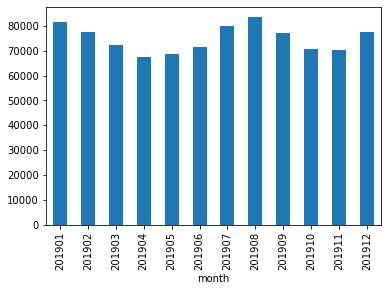

In [29]:
df_final.groupby('month').total_consumption_average.max().plot(kind='bar')

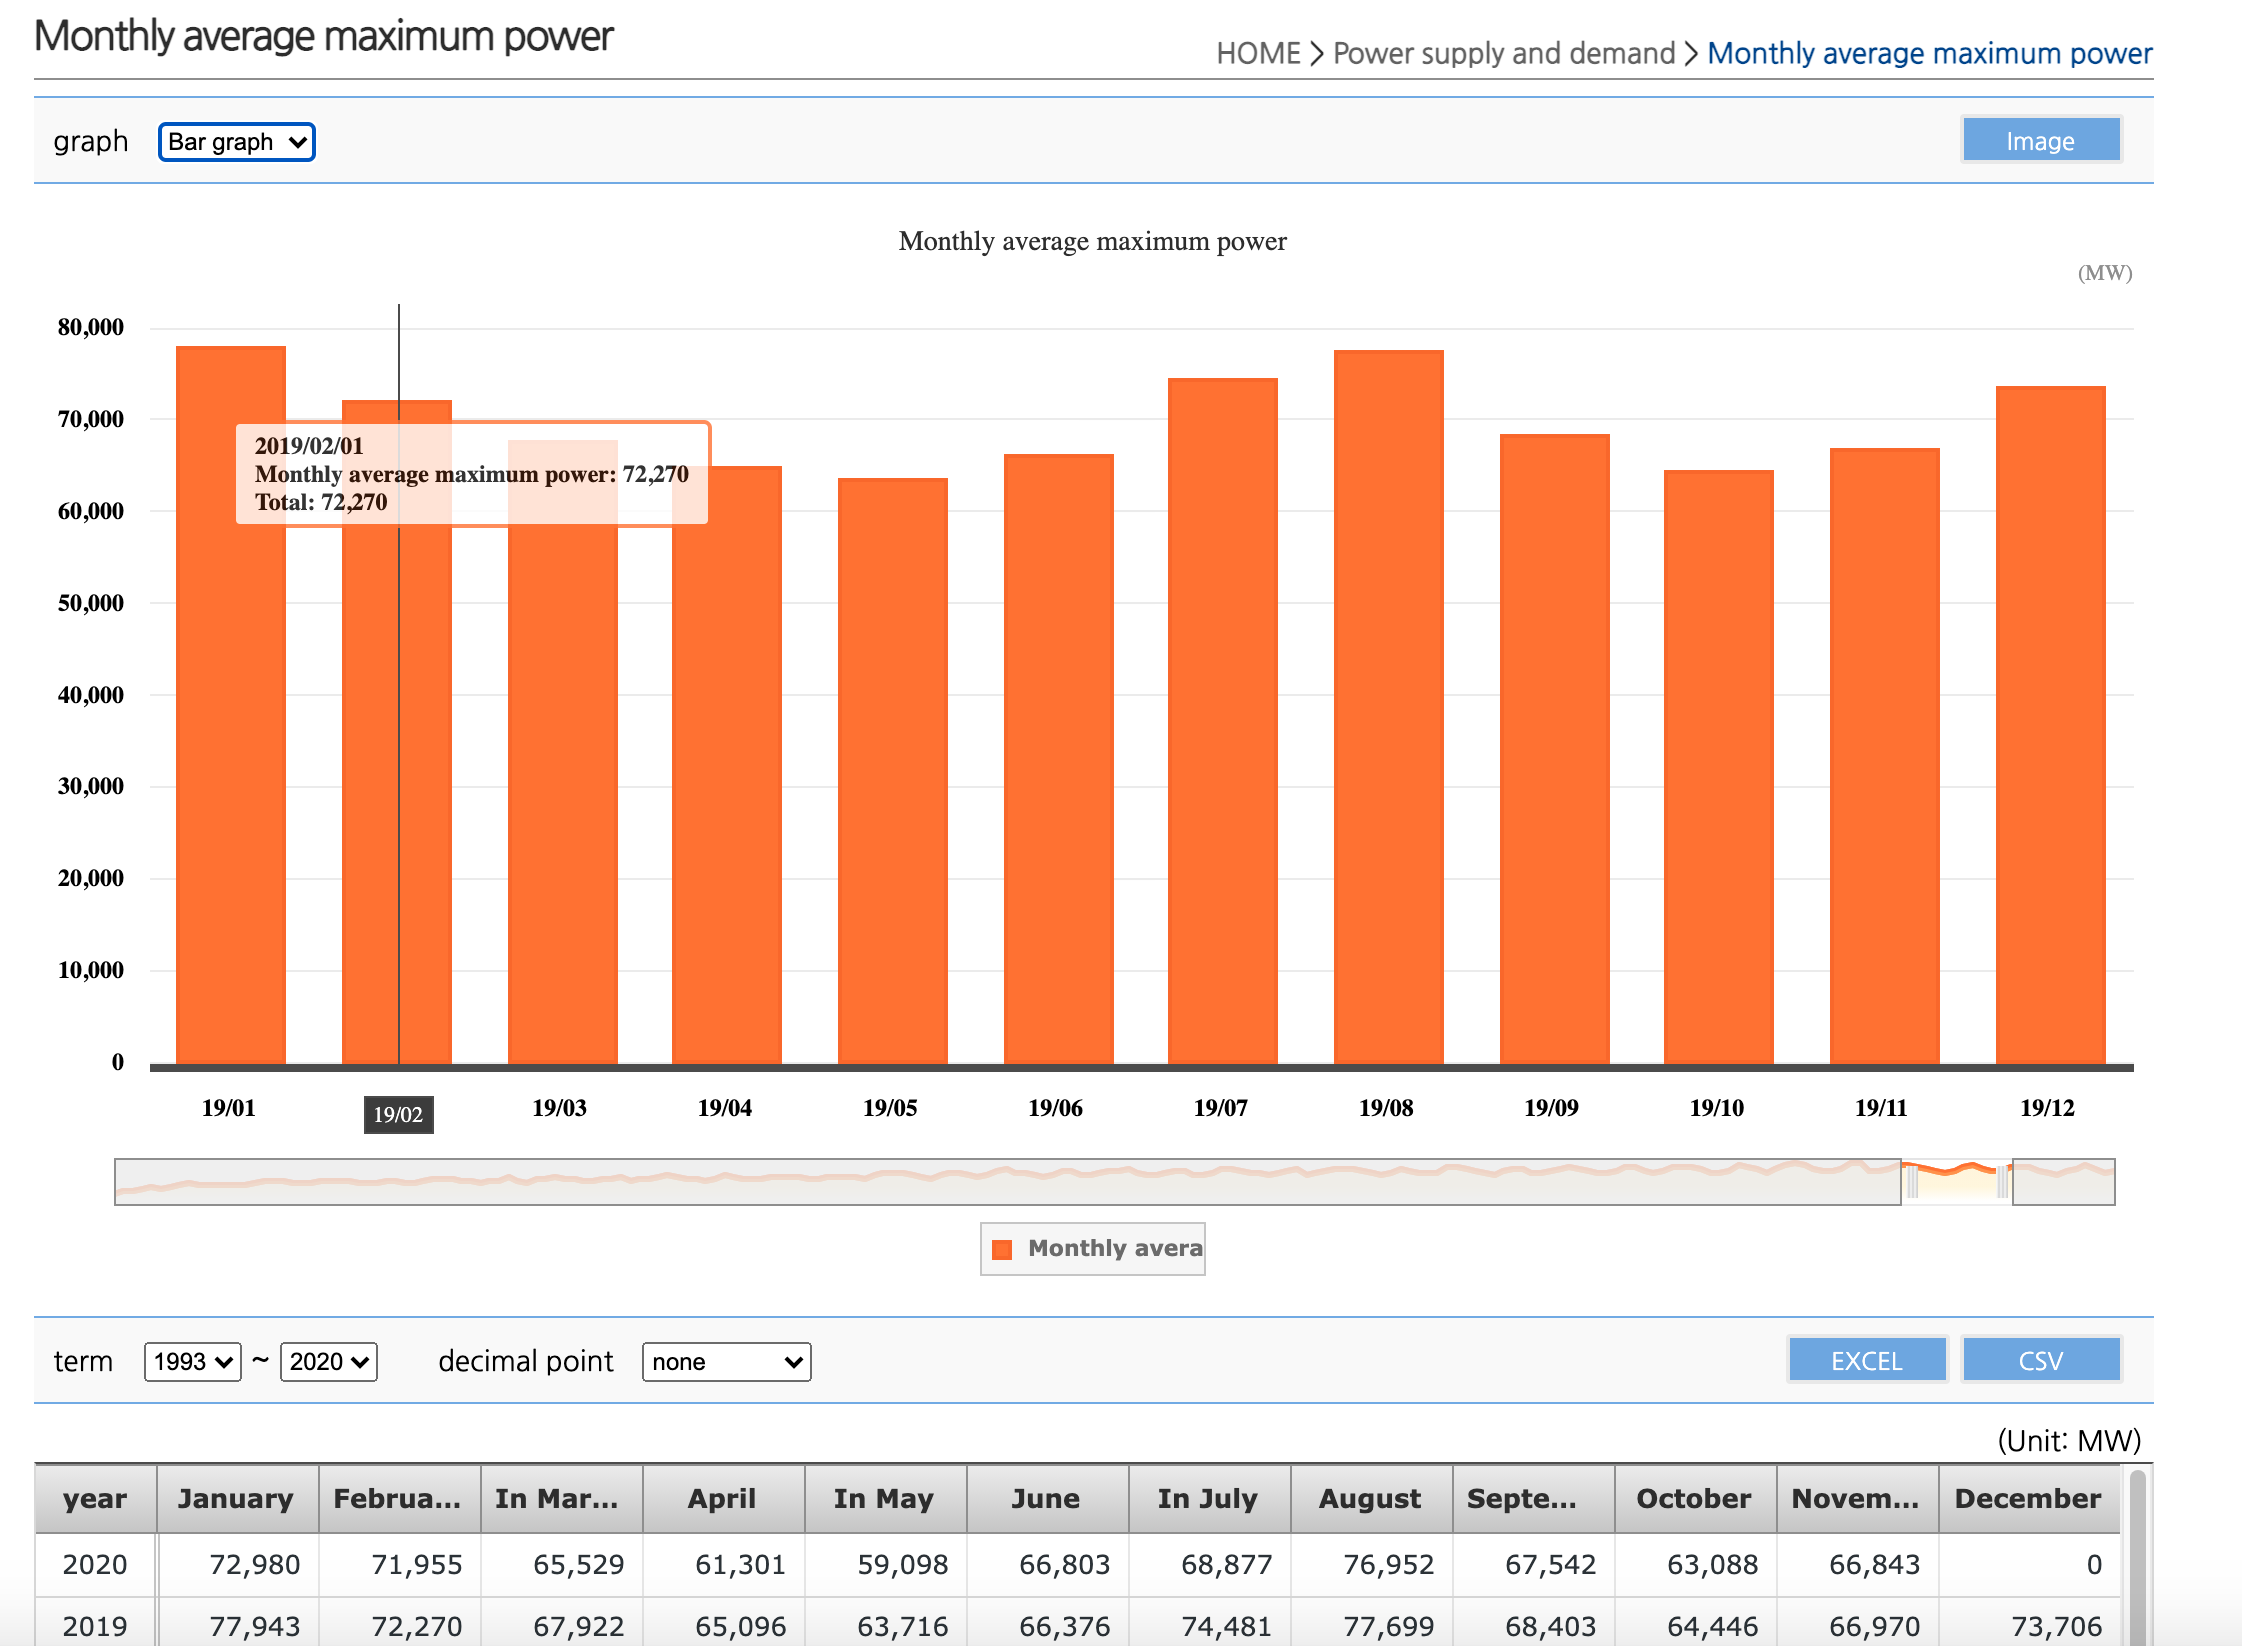

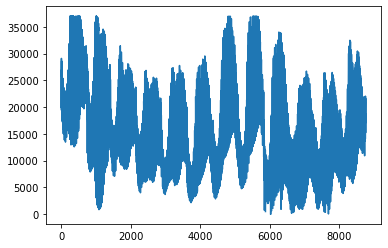

In [30]:
df_final.power_production_coal_avg.plot()

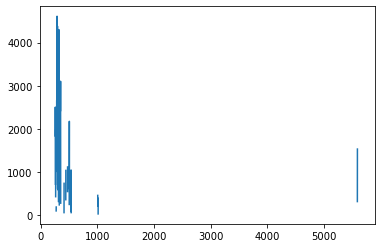

In [31]:
df_final.power_production_gas_avg.plot()